<a href="https://colab.research.google.com/github/punamvekariya68/COMP6721_Project/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
from skimage.feature import hog, graycomatrix, graycoprops
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

Loading and augmenting images...


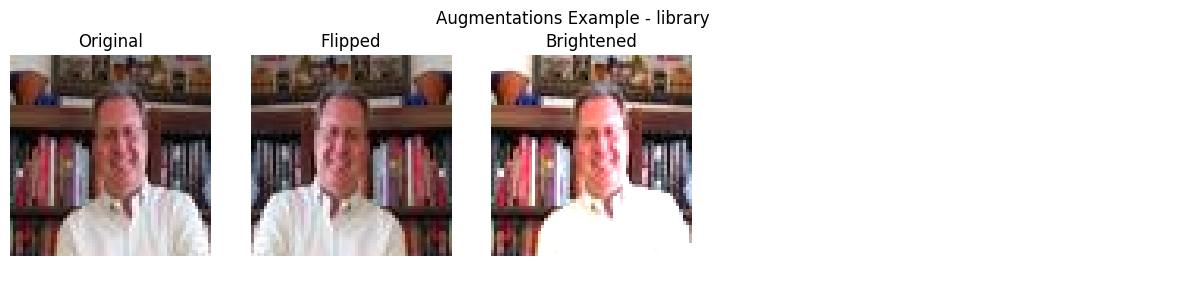

Loaded 45000 total images after augmentation.


In [ ]:
#Step 1: Load Dataset
base_dir = "Training_Resize"
categories = ['library', 'museum', 'shopping_mall']
img_size = (64, 64)

X = []
y = []

print("Loading and augmenting images...")

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
example_shown = False

for label, category in enumerate(categories):
    folder = os.path.join(base_dir, category)
    for filename in os.listdir(folder):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert("RGB").resize(img_size)

            # Original
            X.append(np.array(img))
            y.append(label)

            # Augmentation 1: Horizontal flip
            flipped = ImageOps.mirror(img)
            X.append(np.array(flipped))
            y.append(label)

            # NOT USED: Auto contrast
            # contrast = ImageOps.autocontrast(img)

            # BEST Augmentation 2: Brightness enhancement
            bright = ImageEnhance.Brightness(img).enhance(1.5)
            X.append(np.array(bright))
            y.append(label)

            # NOT USED: Rotation
            # rotated = img.rotate(15)

            if not example_shown:
                axes[0].imshow(img)
                axes[0].set_title("Original")
                axes[1].imshow(flipped)
                axes[1].set_title("Flipped")
                axes[2].imshow(bright)
                axes[2].set_title("Brightened")
#                 axes[3].imshow(ImageOps.autocontrast(img))
#                 axes[3].set_title("Auto Contrast")
#                 axes[4].imshow(img.rotate(15))
#                 axes[4].set_title("Rotated")
                for ax in axes: ax.axis("off")
                plt.suptitle(f"Augmentations Example - {category}")
                plt.show()
                example_shown = True

X = np.array(X)
y = np.array(y)
print(f"Loaded {len(X)} total images after augmentation.")

In [ ]:
print("Extracting features...")

def extract_hog_features(images):
    return np.array([
        hog(rgb2gray(img), pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        for img in images
    ])

def extract_color_histogram(image, bins=32):
    chans = image.transpose(2, 0, 1)
    hist = [np.histogram(ch, bins=bins, range=(0, 256))[0] for ch in chans]
    return np.concatenate(hist)

def extract_glcm_features(img):
    gray = rgb2gray(img)
    gray = (gray * 255).astype(np.uint8)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    return [graycoprops(glcm, p)[0, 0] for p in props]

hog_features = extract_hog_features(X)
color_features = np.array([extract_color_histogram(img) for img in X])
glcm_features = np.array([extract_glcm_features(img) for img in X])

X_combined = np.hstack([hog_features, color_features, glcm_features])
print(f"Combined feature shape: {X_combined.shape}")

Extracting features...
Combined feature shape: (45000, 1866)


In [ ]:
print("Performing SelectKBest feature selection...")

selector = SelectKBest(score_func=f_classif, k=500)
X_selected = selector.fit_transform(X_combined, y)

print("Splitting and scaling features...")
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Feature shape after selection: {X_selected.shape}")

Performing SelectKBest feature selection...
Splitting and scaling features...
Feature shape after selection: (45000, 500)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

print("Training RandomForestClassifier...")

clf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train_scaled, y_train)

print("Random Forest model trained.")
print("Model training complete.")
print("Evaluating on test data...")
y_pred = clf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=categories))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Training RandomForestClassifier...
Random Forest model trained.
Model training complete.
Evaluating on test data...
Accuracy: 0.741

Classification Report:
                precision    recall  f1-score   support

      library       0.70      0.70      0.70      3000
       museum       0.80      0.72      0.76      3000
shopping_mall       0.73      0.80      0.76      3000

     accuracy                           0.74      9000
    macro avg       0.74      0.74      0.74      9000
 weighted avg       0.74      0.74      0.74      9000


Confusion Matrix:
 [[2109  349  542]
 [ 482 2172  346]
 [ 420  192 2388]]


🔍 Tuning 81 RandomForest configurations...



Grid Search: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [21:18<00:00, 15.79s/it]


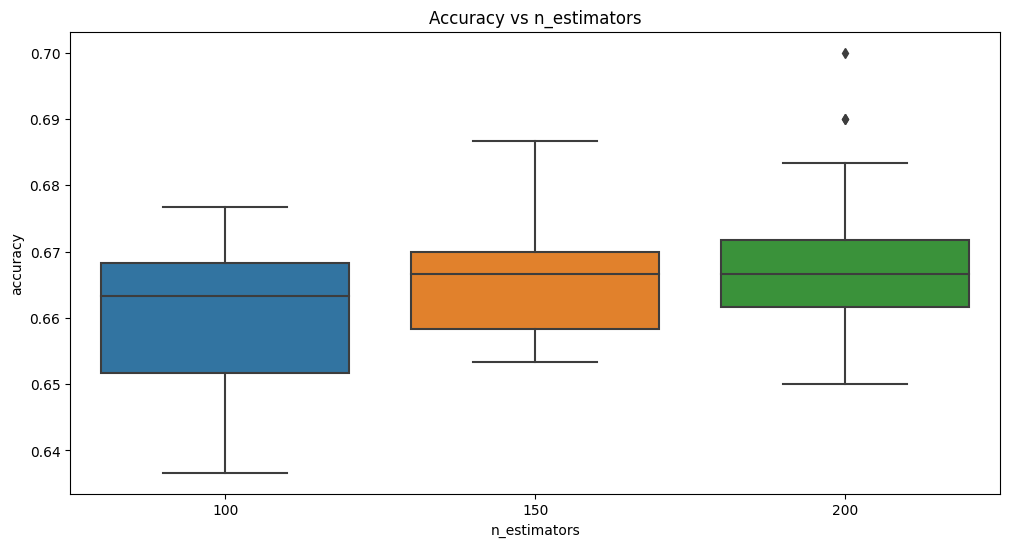

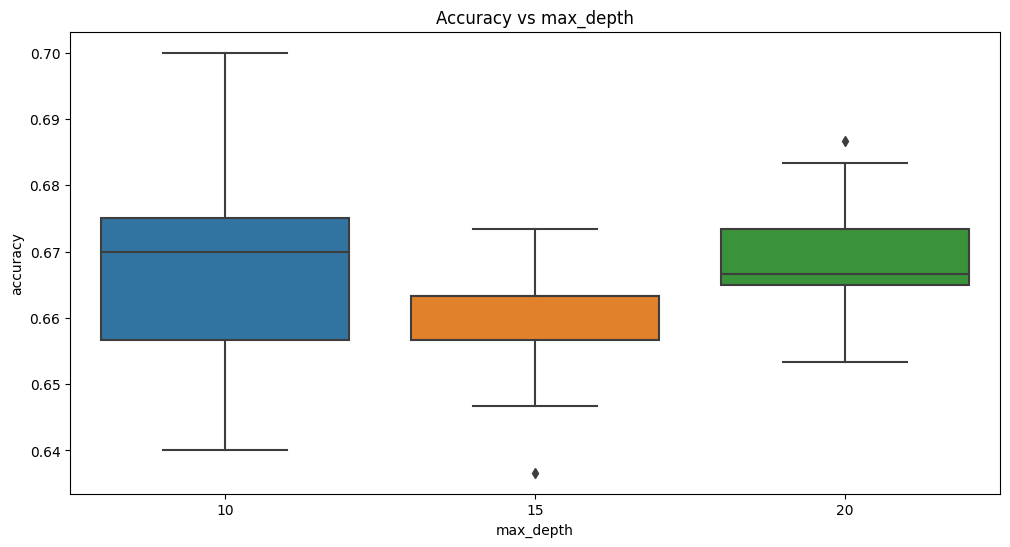

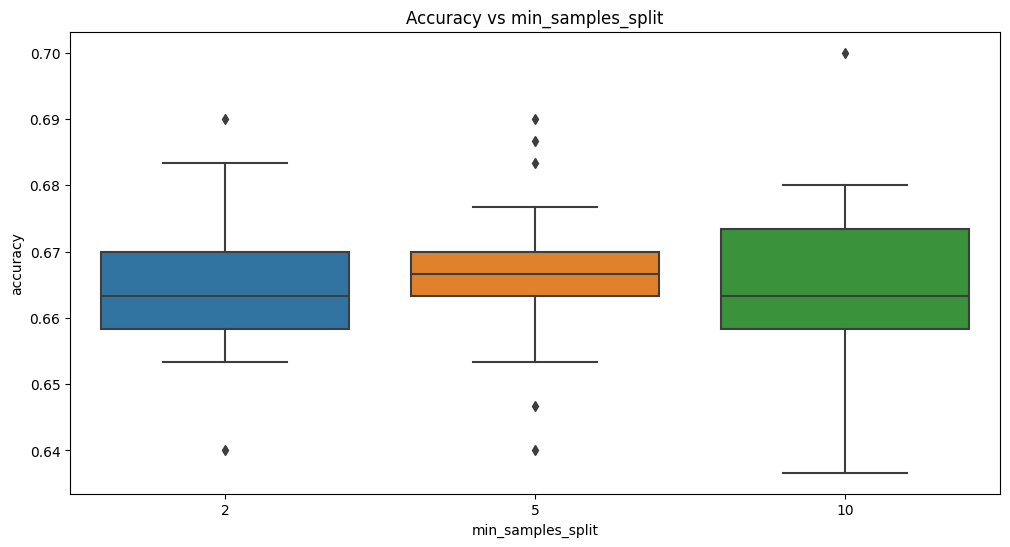

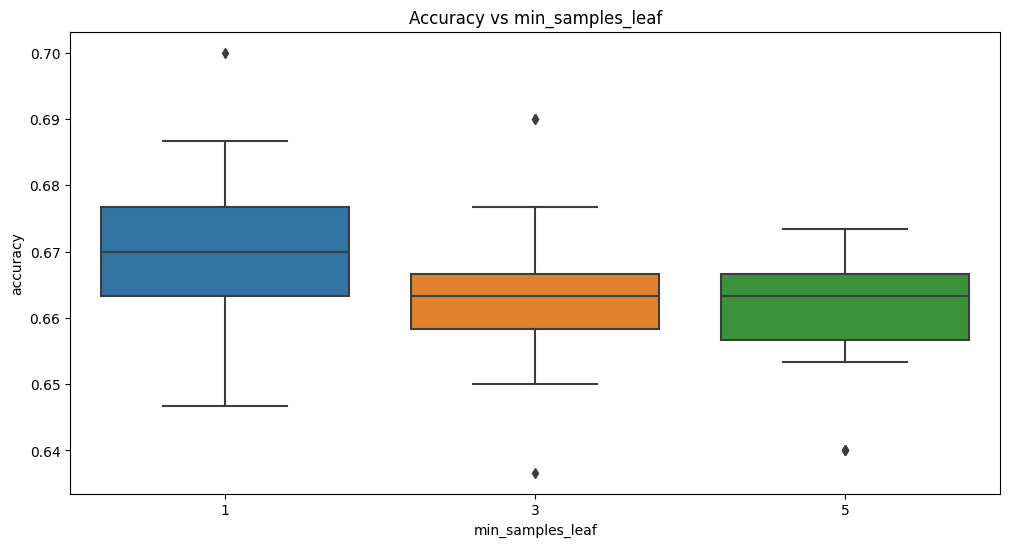


✅ Best Accuracy: 0.7000
🧠 Best Hyperparameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1}


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Hyperparameter grid
param_grid = [
    {"n_estimators": n, "max_depth": d, "min_samples_split": s, "min_samples_leaf": l}
    for n in [100, 150, 200]
    for d in [10, 15, 20]
    for s in [2, 5, 10]
    for l in [1, 3, 5]
]

results = []
best_acc = 0
best_params = None
best_model = None

print(f"Tuning {len(param_grid)} RandomForest configurations...\n")

for params in tqdm(param_grid, desc="Grid Search"):
    clf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **params
    )
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "params": params,
        "accuracy": acc
    })

    if acc > best_acc:
        best_acc = acc
        best_params = params
        best_model = clf

#Save best model
with open("best_rf_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

#Convert results to DataFrame for plotting
df = pd.DataFrame(results)
df['n_estimators'] = df['params'].apply(lambda x: x['n_estimators'])
df['max_depth'] = df['params'].apply(lambda x: x['max_depth'])
df['min_samples_split'] = df['params'].apply(lambda x: x['min_samples_split'])
df['min_samples_leaf'] = df['params'].apply(lambda x: x['min_samples_leaf'])

#Plot results
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='n_estimators', y='accuracy')
plt.title("Accuracy vs n_estimators")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='max_depth', y='accuracy')
plt.title("Accuracy vs max_depth")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='min_samples_split', y='accuracy')
plt.title("Accuracy vs min_samples_split")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='min_samples_leaf', y='accuracy')
plt.title("Accuracy vs min_samples_leaf")
plt.show()

#Print best result
print(f"\nBest Accuracy: {best_acc:.4f}")
print("Best Hyperparameters:", best_params)


In [ ]:
import pickle

# Save model and scaler
with open("RF.pkl", "wb") as f:
    pickle.dump(clf, f)

with open("RFscaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("RFselector.pkl", "wb") as f:
    pickle.dump(selector, f)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Train Random Forest with best parameters
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train_scaled, y_train)

#Evaluate
y_pred = clf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['library', 'museum', 'shopping_mall']))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6704444444444444

Classification Report:
                precision    recall  f1-score   support

      library       0.61      0.64      0.62      3000
       museum       0.77      0.60      0.68      3000
shopping_mall       0.66      0.77      0.71      3000

     accuracy                           0.67      9000
    macro avg       0.68      0.67      0.67      9000
 weighted avg       0.68      0.67      0.67      9000


Confusion Matrix:
 [[1921  361  718]
 [ 719 1810  471]
 [ 519  178 2303]]


In [ ]:
import os
import numpy as np
from PIL import Image
from skimage.feature import hog, graycomatrix, graycoprops
from skimage.color import rgb2gray
import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

categories = ['library', 'museum', 'shopping_mall']
test_dir = "Test_Resize"
img_size = (64, 64)

# Feature extraction functions
def extract_hog_features(images):
    return np.array([
        hog(rgb2gray(img), pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        for img in images
    ])

def extract_color_histogram(image, bins=32):
    chans = image.transpose(2, 0, 1)
    hist = [np.histogram(ch, bins=bins, range=(0, 256))[0] for ch in chans]
    return np.concatenate(hist)

def extract_glcm_features(img):
    gray = rgb2gray(img)
    gray = (gray * 255).astype(np.uint8)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    return [graycoprops(glcm, p)[0, 0] for p in props]

# Load and preprocess test data
X_test = []
y_test = []
filenames = []

for label, category in enumerate(categories):
    category_dir = os.path.join(test_dir, category)
    for fname in os.listdir(category_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(category_dir, fname)
            img = Image.open(path).convert("RGB").resize(img_size)
            img_np = np.array(img)

            hog_feat = hog(rgb2gray(img_np), pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
            color_feat = extract_color_histogram(img_np)
            glcm_feat = extract_glcm_features(img_np)

            features = np.hstack([hog_feat, color_feat, glcm_feat])
            X_test.append(features)
            y_test.append(label)
            filenames.append(fname)

X_test = np.array(X_test)
X_test_selected = selector.transform(X_test)
X_test_scaled = scaler.transform(X_test_selected)
y_pred = clf.predict(X_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=categories))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(clf, X_train_scaled, y_train, cv=5)
# print(f"Cross-val accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


Accuracy: 0.7

Classification Report:
                precision    recall  f1-score   support

      library       0.64      0.66      0.65       100
       museum       0.74      0.67      0.71       100
shopping_mall       0.72      0.77      0.74       100

     accuracy                           0.70       300
    macro avg       0.70      0.70      0.70       300
 weighted avg       0.70      0.70      0.70       300


Confusion Matrix:
 [[66 15 19]
 [22 67 11]
 [15  8 77]]
